In [4]:
from IPython.display import display, Image

# Assessment of intracranial biomechanical properties using gaussian process regression, physics based simulations and intracranial pressure monitoring

## Intracranial biomechanical properties

Assessment of intracranial biomechanical properties by measuring intracranial pressure (ICP) variations during lumbar infusion study (see Figure) can give precious information in patients suspected of CSF disorders, in particular in chronic hydrocephalus [1]. 

Resistance to CSF outflow $R_{CSF}$, has been the most studied hydrodynamic parameter. A high $R_{CSF}$ (cut-off generally admitted > 12mmHg/ml/min) is considered as a good marker of hydrocephalus. 
The central nervous compliance $C=\frac{d V}{d P}$ evaluate the cranio-spinal capacity to adapt to a change of pressure. 
Marmarou et al. [2] showed that the craniospinal volume–pressure relationship can be considered as mono-exponential. And the compliance expression is usually assumed as $C(P)=\frac{1}{E(P-p_0)}$ with $P$ the intracranial pressure, $E$ the elastance coefficient (unit 1/ml) and $p_0$ a reference pressure.

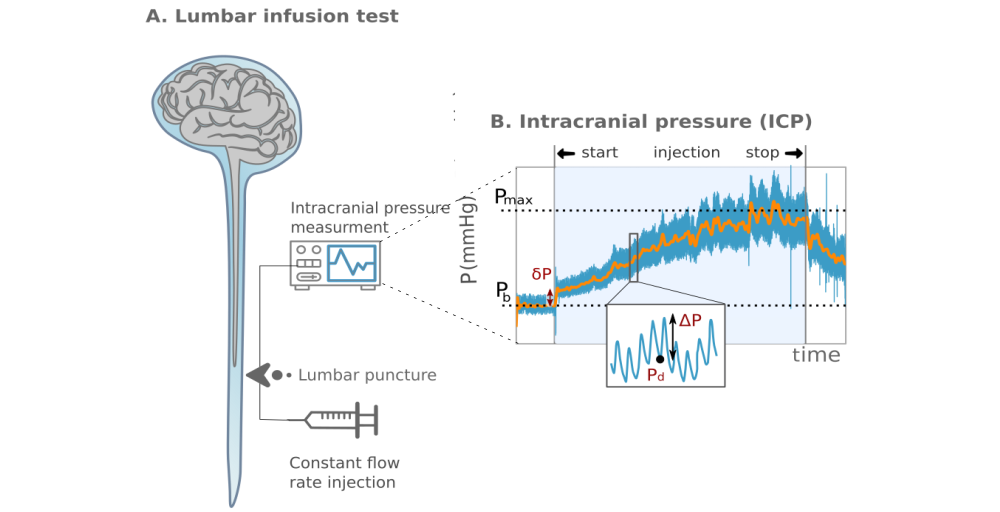

In [5]:
display(Image(filename='./Images/Infusiontest.png'))

__Figure 1:Lumbar infusion test, typical intracranial pressure measurements and analysis__. 

__Panel A__ – Lumbar infusion test scheme: The intracranial pressure (ICP) is measured while a saline fluid is injected at a constant flow rate through a lumbar puncture. __Panel B__ - ICP evolution during the infusion test. Blue line: ICP measurement; orange line: smoothed ICP (low pass filter). The mean pressure at plateau, Pmax and the mean pressure at baseline, Pb, are indicated in black dotted lines. The pressure artefact induced by the needle, δP, the ICP amplitude, ΔP, and the diastolic pressure, Pd, are indicated in red.

## A simple model of intracranial pressure 

Marmarou proposed a simple model of the intracranial pressure : the CSF is produced at a constant rate $I_{production}$ and is reabsorbed at the location of the arachnoid villis at a rate $I_{absorption}$. The arachnoid villis behave like a valve and the reabsorption rate depends on the pressure differencial between the intracranal pressure $P$,the pressure in the sagital sinus $P_{sagitalsinus}$ and on the resistance to CSF outflow $R_{CSF}$ : $
I_{absorption}=\frac{P-P_{sagitalsinus}}{R_{CSF}}$.


The intracranial pressure depends on the volume of CSF, according the the compliance relationship $\frac{d P}{d V}=1/C(P)$. And the volume variation during infusion test is $\frac{d V}{d t}=I_{production}+I_{infusion}-I_{absorption}$,with $I_{infusion}$ the rate of lumbar saline fluid injection. 

After integration, the expression of the intracranial pressure during the infusion test is

$$
P^M(t)=\frac{(I_{production}+I_{infusion})(P_{baseline}-p_0)}{I_{production}+I_{infusion}\exp[-E(I_{production}+I_{infusion})t]}+p_0
$$

with $P_{baseline}$ the mean intracranial pressure at rest, before the infusion test. 

The equilibrium of CSF production and reabsorption at baseline leads to 

$$
I_{production}=I_{absorption}=\frac{P_{baseline}-P_{sagital sinus}}{R_{CSF}}
$$


After some simplificaitons, the model of the intracranial pressure $P^M(t)$ depends on 5 parameters : 
$
(E, R_{CSF},p_0,P_{baseline}, I_{infusion})
$.

As $I_{infusion}$ is imposed and $P_{baseline}$ can be measured quite precisely, it remains only $m_\theta=3$ parameters to be calibrated : 
$$
\theta =(E, R_{CSF},P_{baseline}-p_0)
$$.


## Parameters inference 

We consider three distinctive processes : 
* __R__ represents the ideal reality (never exactly known).
* __F__ represents the field of observations (the clinical measurments).
* **M** represents the computer simulation that solves a mathematical model idealizing __R__.

Let consider a set of $m_t$ known times $t$ where we measure the intracranial pressure. $P^F(t)$ is the intracranial pressure observation at time $t$. 
$P^R(t)$ denote the real intracranial pressure at time t. 

The clinical observation and the reality are related as follow :
$P^F(t)=P^R(t) + \epsilon$ where $\epsilon \sim \mathcal{N} (0,\sigma_\epsilon^2)$.

We have a computer model $P^M(t,\theta)$ that implement a mathematical model of the intracranial pressure. It depends on $\theta$ : the $m_\theta$ callibration parameters of the model. Those are parameters that can't be controlled in the experiments and that are unknown in **R** but are needed in the model __M__. 

Here the parameters are : 
- the eslatance coefficient
- the resitance to CSF outflow
- the reference pressure

The goal is to study the relation-ship between the computer model outputs $P^M(t,\theta)$ and the field $P^F(t)$ in order to learn about the real phenomena $P^R(t)$.


### Kennedy and O’Hagan framework (KOF) ###

Let note $\theta \star$ the best-fitting callibration parameters. We note the model discepency $b(t)$
 the disagreement beween the computational model and the reality :
 
$$ P^R(t)=P^M(t,\theta \star) + b(t)$$

Wich mean that disagreement between the observations and the computational model are

$$ P^F(t)=P^M(t,\theta \star) + b(t)+\epsilon$$.

The functiona discrepancy $b(.)$ is refered to as model bias correction. For simplicity we will consider that $b(.)$ has a zero-mean.

Altogether the unknowns are $\theta \star$, $\sigma^2_\epsilon$ and $b(.)$.


Even if we do not know the exact values of the callibration parameters $\theta \star$ we may have an idea of the range of values where those parameters should be and on the probability distribution function thanks to in-vivo measurments reported in the litterature. Thus we will provide restriction on the $\theta$ values through prior distribution $\pi(\theta)$.


If the computer model is computationnaly expensive, we can use a surrogate model instead $\hat P^M(.,.)$ which has been fitted to $n_M$ simluations of **M** over a sampling design in the $(t,\theta)$ space. 

In this exemple the foward simulation with the computer model is fast. Thus the sensitivity analysis and the inference can be done directly with this model. However we also construct a surrogate model to test the method that could be used for the assessment of paramters of more complex models (e.g. inctracranial blood circulation).

Here we will use a surrogate model independant of the observation data using only the $n_M$ simulations. This is an approach called the KOF modularization approach.

In [3]:
import numpy as np
import openturns as ot
import pylab as pl
from openturns.viewer import View
%matplotlib inline

In [5]:
def PIC_raw(t, E, RCSF,PbmP0, Iinf):
    """
    Input : 
    x : array of floats [t, E, RCSF,P0,Pb, Iinf]
        with : 
        t : time after the begining of infusion test
        E : elastance coefficient
        Rcsf : resistance to reabsoption of the CSF
        P0: reference pressure
        Pb : baseline intracranial pressure
        Iinf : infusion rate
    
    Output : 
    p : intracranial pressure
    """
    Ib=(PbmP0)/RCSF
    p=(Ib+Iinf)*(PbmP0)/(Ib+Iinf*np.exp(-E*(Ib+Iinf)*t))-PbmP0
    return p

We define a function $PIC(\theta)$ that resurn $P(t,\theta)$ for a set of given times.

In [6]:
# We chose a set of times where will be done the observation.

spantemps=np.arange(0.5,10,0.5)
# A new function pic with fixed value for Iinf
def PIC(x):
    """
    Input : 
    x : array of floats [t, E, RCSF,P0,Pb, Iinf]
        with : 
        t : time after the begining of infusion test
        E : elastance coefficient
        Rcsf : resistance to reabsoption of the CSF
        P0: reference pressure
        Pb : baseline intracranial pressure
        Iinf : infusion rate
    
    Output : 
    p : intracranial pressure
    """
    x=np.hstack(x)
    E, RCSF,PbmP0=x
    return PIC_raw(spantemps, E, RCSF,PbmP0,1.5)


Let visualize the intracranial pressure predicted by the computer model for a given set of parameters $\theta$ :

Text(0.5, 0, 'time (min)')

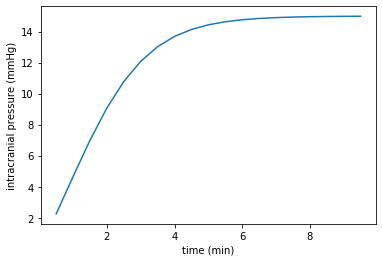

In [7]:
theta=[0.4,10,7,1.5]
pl.plot(spantemps,PIC_raw(spantemps,*theta))
dimoutput=len(spantemps)
pl.ylabel('intracranial pressure (mmHg)')
pl.xlabel('time (min)')

We define the function using the openturns class.

In [8]:
OT_SimulationInfusion=ot.PythonFunction(3,19,PIC)

# Surrogate model

The first step consists of exploring the parameter space in a precise and economical way. 


### Distribution of the variables for the construction of the surrogate model

We define the prior distribution $\pi(\theta)$.


| Input Variable | Description | Distribution | Mean   | Var |
|----------|-------------|--------------|---------|------------|
| $E$        | elastance coefficient (/ml)  | Lognormale |  0.5 | 0.15       |
| $Rcsf$        | resistance to CSF outflow (mmHg/ (ml/min))  | Lognormale   |  12    | 4        | 
| $P_b - P_0$        | reference pressure (mmHg) | Lognormale   |   6   | 2        | 


In [12]:
E = ot.LogNormal() 
E.setParameter(ot.LogNormalMuSigma()([0.5,0.15, 0]))
E.setDescription(['Elastance'])

Rcsf = ot.LogNormal() 
Rcsf.setParameter(ot.LogNormalMuSigma()([12,4, 0]))
Rcsf.setDescription(['Resistance CSF outflow'])

PbmP0 = ot.LogNormal() 
PbmP0.setParameter(ot.LogNormalMuSigma()([6,2, 0]))
PbmP0.setDescription(['Reference pressure'])


distribution = ot.ComposedDistribution([ E, Rcsf, PbmP0])
description = ( 'E', 'Rcsf', 'PbmP0')
distribution.setDescription(description)

dim=len(description)

### In silico experimental design

We create an Optimized Latin Hypercube sampling to cover the the variables space.

In [13]:
#Number of points of experiments
size=100
# Optimized Latin Hypercube sampling
lhs=ot.LHSExperiment(distribution, size, True)
mc_lhs=ot.MonteCarloLHS(lhs,10000)

#Input
inputSample=mc_lhs.generate()
#Output
outputSample=OT_SimulationInfusion(inputSample)

### Gaussian process regression

#### Deterministic part

In [14]:
# Could be constant, linear or quadratic. Or legendre, polynomial, bessels, fourrier... 
# We should select was is the best suited to the problem.
# Here we consider a simple linear basis.
basis=ot.LinearBasisFactory(dim).build()

#### Covariance model

In [15]:
# Could be Matern
covCol=[ot.MaternModel([1.],2.5)]*dim
cov=ot.ProductCovarianceModel(covCol)

#or squared exponential
#covCol= [ot.SquaredExponential([1.], [1.0])]*dim
#cov=ot.ProductCovarianceModel(covCol)

#### Kriging algorithm¶

In [16]:
# Instanciation
algokriging=ot.KrigingAlgorithm(inputSample,outputSample,cov,basis)

In [17]:
#Optimisation
N=50
startingPoint=ot.LHSExperiment(ot.ComposedDistribution([ot.Uniform(1e-2,1e3)]*(dim+dimoutput)),N).generate()
algokriging.setOptimizationAlgorithm(ot.MultiStart(ot.TNC(),startingPoint))

In [18]:
# run
algokriging.run()

### Results

In [19]:
# get some results
krigingResult = algokriging.getResult()
print('residual = ', krigingResult.getResiduals())
print('R2 = ', krigingResult.getRelativeErrors())
print('Optimal scale= {}'.format(krigingResult.getCovarianceModel().getScale()))
print('Optimal amplitude = {}'.format(krigingResult.getCovarianceModel().getAmplitude()))
print('Optimal trend coefficients = {}'.format(krigingResult.getTrendCoefficients()))

# get the metamodel
krigingMeta=krigingResult.getMetaModel()

residual =  [1.37036e-11,4.05838e-11,1.6403e-10,1.7736e-10,1.09956e-10,2.51706e-10,3.18493e-10,4.34407e-10,3.90242e-10,3.11361e-10,1.86945e-10,1.21549e-10,3.55371e-10,1.93231e-10,2.94539e-10,2.47568e-10,3.50333e-10,2.14539e-10,2.16284e-10]#19
R2 =  [1.32113e-20,2.90844e-20,2.42881e-19,1.98216e-19,6.18833e-20,2.84689e-19,4.1808e-19,7.31906e-19,5.64041e-19,3.45789e-19,1.20686e-19,4.95951e-20,4.13608e-19,1.19727e-19,2.73265e-19,1.90232e-19,3.76387e-19,1.39791e-19,1.40983e-19]#19
Optimal scale= [10.9941,9.80898,11.4744]
Optimal amplitude = [100,100,100,100,19.6933,100,61.4698,100,100,100,100,100,100,100,100,100,100,100,100]#19
Optimal trend coefficients = [[-1.18699,0.23078,0.770496,0.418842],[-6.37557,-0.390147,2.44003,-0.00527987],[-2.14936,-0.282867,2.86334,0.0246214],[14.2859,0.811557,1.78487,0.223942],[30.0288,1.62242,0.399862,-0.392402],[32.8785,1.89102,-0.801487,-1.1847],[21.5195,2.3482,-1.87526,-1.11776],[2.28272,3.43767,-2.80016,0.0152129],[-17.5565,4.98626,-3.45722,1.75846],[-33.

### Validation

Q2 Kriging = 0.9999360


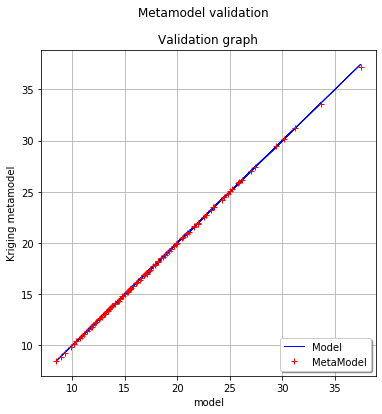

In [20]:
#output selection
OutputID=18

# Sample creation
sizeTest=100
Xtest=ot.LowDiscrepancyExperiment(ot.SobolSequence(),distribution,sizeTest).generate()

# True value
Ytest=OT_SimulationInfusion(Xtest)[:,OutputID]

fig,ax=pl.subplots(figsize=(6,6))

# Validation of the model
val = ot.MetaModelValidation(Xtest,Ytest,krigingMeta.getMarginal(OutputID))

# Compute the first indicator : q2
q2 = val.computePredictivityFactor()

# Get the residual
residual = val.getResidualSample()

# Get the histogram of residual
histoResidual = val.getResidualDistribution(False)

# Draw the validation graph
View(val.drawValidation(),axes=[ax])
ax.set_ylabel('Kriging metamodel')
ax.set_title('Validation graph')

print('Q2 Kriging = %0.7f'%q2)

We observe that the surrogate model predictions are close to the model outputs, since the red points are very close to the diagonal.

Comparison of the foward simulation outputs $P^M(t,\theta)$ and the surrogate output $\hat P^M(t,\theta)$

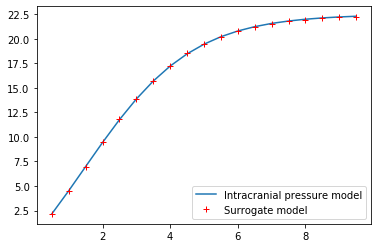

In [22]:
theta=[0.3,15,9]
pl.plot(spantemps,OT_SimulationInfusion(theta),label='Intracranial pressure model')
pl.plot(spantemps,krigingMeta(theta),'+r',label='Surrogate model')
pl.legend()

We have an excellent agreement. 

# Sensitivity analysis

We would like to analyse the sensivility of the model upon the parameters using sobol' indices and to compare the results when the analysis is performed directly with the model $P^M(t,\theta)$ or the surrogate $\hat P^M(t,\theta)$

Working within a probabilistic framework, we decompose the variance of the output of the model into fractions which can be attributed to inputs paramters $\theta_i$ or sets of inputs parameters ${\theta_i}$.

A direct variance-based measure of sensitivity $S_i$, called the "first-order sensitivity index", or "main effect index" is stated as follows
$$
S_i=\frac{Var_{\theta_i}(E_{\theta_{j, j\neq i}}(Y|\theta_i)}{Var(P)}
$$


The coefficient $S_i$ is called a Sobol' coefficient. It is the contribution to the output variance of the main effect of $\theta_i$, therefore it measures the effect of varying $\theta_i$ alone, but averaged over variations in other input parameters.

Higher-order interaction indices $S_{ij}$, $S_{ijk}$ and so on can be formed by dividing other terms in the variance decomposition by Var(Y and quantify the contribution of the interaction of paramters.

The sum of all contributions, is equal to 1. Thus the contribution of the interaction of paramters is evaluated as
$$
S_{interactions}= \sum_{i<j<k}^{N}{S_{ij}+S_{ijk}+...+S_{1,2,...,N}}=1-\sum_{i=1}^{N}{S_i}
$$ 


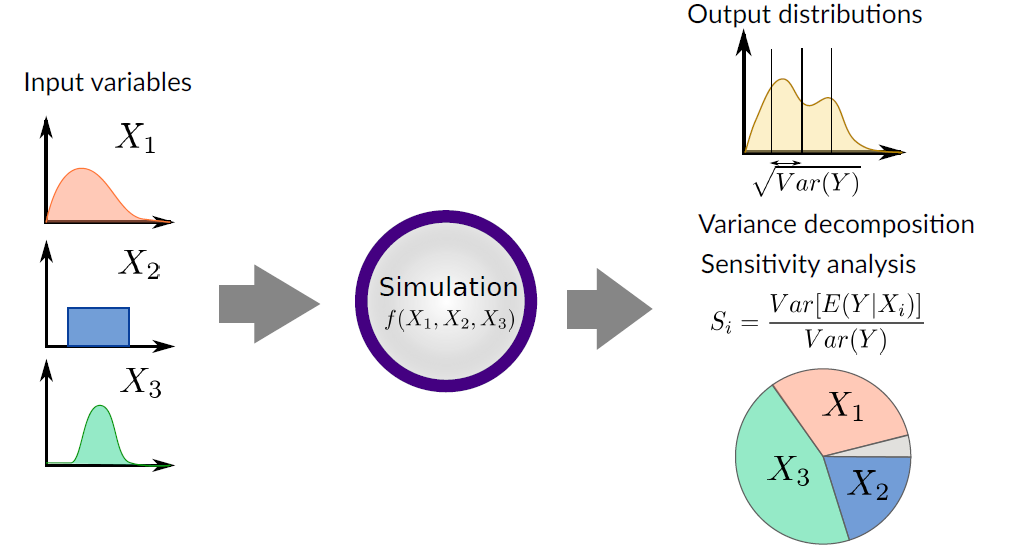

In [6]:
display(Image(filename='./Images/sensitivityanalysis.png'))

### Sampling

In [23]:
# Input Design
size = 5000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
inputDesign.setDescription(description)
inputDesign.getSize()

25000

### Using the foward simulations

In [24]:
# Output design 
outputDesign = OT_SimulationInfusion(inputDesign)

#### Estimation of Sobol' indices

In [25]:
#sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

Text(0, 0.5, "Sobol' indices")

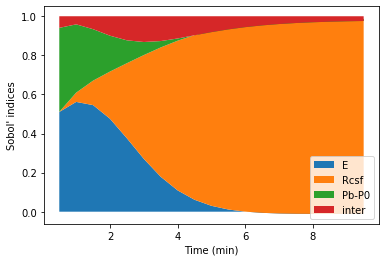

In [26]:
sobol_E=[]
sobol_R=[]
sobol_P=[]
sobol_inter=[]

labels=['E','Rcsf','Pb-P0','inter']

for i in range(19):
    firstOderIndices=sensitivityAnalysis.getFirstOrderIndices(i)
    sobol_E.append(firstOderIndices[0])
    sobol_R.append(firstOderIndices[1])
    sobol_P.append(firstOderIndices[2])
    sobol_inter.append(1-sum(firstOderIndices))
    
fig,ax=pl.subplots()
ax.stackplot(spantemps,sobol_E,sobol_R,sobol_P,sobol_inter,labels=labels)
ax.legend(loc=4) 
pl.xlabel('Time (min)')
pl.ylabel('Sobol\' indices') 

We can see that at the begining of the infusion test $(t<3 min)$, the intracranial pressure depends mostly on the elastance and reference pressure parameters. At later times, the intracranial pressure depends mainly on the resistance to CSF outflow. This is because at late time, the intracranial pressure depends mainly on the equilibrium between the Infusion rate and the rate CSF outflow which depends on $R_{CSF}$.

### Using the metamodel

In [27]:
# Output design 
outputDesign = krigingMeta(inputDesign)

In [28]:
# Estimate Sobol' indices

In [29]:
#sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

Text(0, 0.5, "Sobol' indices")

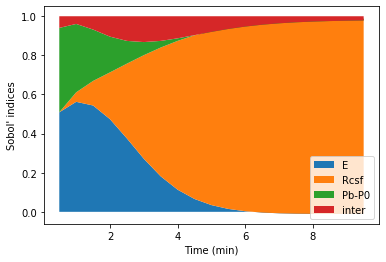

In [30]:
sobol_E=[]
sobol_R=[]
sobol_P=[]
sobol_inter=[]

labels=['E','Rcsf','Pb-P0','inter']

for i in range(19):
    firstOderIndices=sensitivityAnalysis.getFirstOrderIndices(i)
    sobol_E.append(firstOderIndices[0])
    sobol_R.append(firstOderIndices[1])
    sobol_P.append(firstOderIndices[2])
    sobol_inter.append(1-sum(firstOderIndices))
    
fig,ax=pl.subplots()
ax.stackplot(spantemps,sobol_E,sobol_R,sobol_P,sobol_inter,labels=labels)
ax.legend(loc=4) 
pl.xlabel('Time (min)')
pl.ylabel('Sobol\' indices') 

We obtain a very similar results. Thus the surrogate model here can be used instead of the direct foward computer model in order to estimate the sobol' coefficients.This could be very usefull if the foward simulation is CPU time consuming.

# Inference of parameters

In this section, the "true" value of the parameters $\theta _T$ is used to compute the model output. We add some artificial observational noise to mimic a real clinical measurement. Then we will apply an bayesian callibration algorythm to recover the value of $\theta_T$ using the foward computer model and the metamodel, for comparison.

In [31]:
# Let define a "true" value for theta that we would like to infer
# theta = [E,Rcsf,Pb-P0]
thetatrue=[0.8,15,7]

### Using the direct foward computer model 

We redefine the callibration parameters as $\tilde \theta = \ln(\theta)$ in order work with normal distributions.
The function that compute the intracranial pressure is modified accordingly.

In [32]:
logthetatrue=np.log(thetatrue)

In [33]:
def PIC_logarg(x):
    """
    Input : 
    x : array of floats [t, E, RCSF,P0,Pb, Iinf]
        with : 
        t : time after the begining of infusion test
        E : elastance coefficient
        Rcsf : resistance to reabsoption of the CSF
        P0: reference pressure
        Pb : baseline intracranial pressure
        Iinf : infusion rate
    
    Output : 
    p : intracranial pressure
    """
    
    x=np.hstack(x)

    t,logE, logRCSF,logPbmP0=x
    
    E=np.exp(logE)
    R=np.exp(logRCSF)
    PB=np.exp(logPbmP0)
    
    Iinf=1.5
    Ib=PB/R
    p=(Ib+Iinf)*(PB)/(Ib+Iinf*np.exp(-E*(Ib+Iinf)*t))-PB    
   
    return [p]

We define the parametric model $g = y^M(t,\theta)$ that associates each observation $t_i$ and values of the parameters $\theta_i$ to the parameters of the distribution of the corresponding observation. Here $z=(\mu, \sigma)$ where $\mu$, the first output of the model, is the mean and $\sigma$, the second output of the model, is the standard deviation.

For that purpose we first define a full model function that return the value of the pressure as well as the standard deviation associated with the uncertainlty of the measurements.

In [68]:
def g(X):
    p = PIC_logarg(X)[0]
    sigmap = 2 # (mmHg) The standard deviation of the observation error.
    return [p,sigmap]

fullModel = ot.PythonFunction(4, 2, g)

Then we define the parametric model g. Here the input variable $t$ has the index 0.

In [69]:
input_indexes=[0]
arbitrary_inputs=[0]
model = ot.ParametricFunction(fullModel, input_indexes, arbitrary_inputs)

Let say that we have 10 points of observations, ie. 10 points of measurement for the intracranial pressure at differents times. Each observation points is associated with an uncertainly. 

We define the times of obervations

In [70]:
obs_dim=10

#### Fabrication des temps d'observation
tmin = 0.5
tmax = 10.
step = (tmax-tmin)/(obs_dim-1)
rg = ot.RegularGrid(tmin, step, obs_dim)
x_obs = rg.getVertices()

We define the observation noise $\varepsilon {\sim} \mathcal N(0, 1)$ and create a sample from it.

In [71]:
ot.RandomGenerator.SetSeed(0)
noiseStandardDeviation = 0.5 ##mmHg
noise = ot.Normal(0,noiseStandardDeviation)
noiseSample = noise.getSample(obs_dim)

We define the vector of observations, using the "true" value of the parameters.

In [72]:
y_obs = ot.Sample(obs_dim,1)
for i in range(obs_dim):
    model.setParameter(x_obs[i])
    y_obs[i,0] = model(logthetatrue)[0] + noiseSample[i,0]

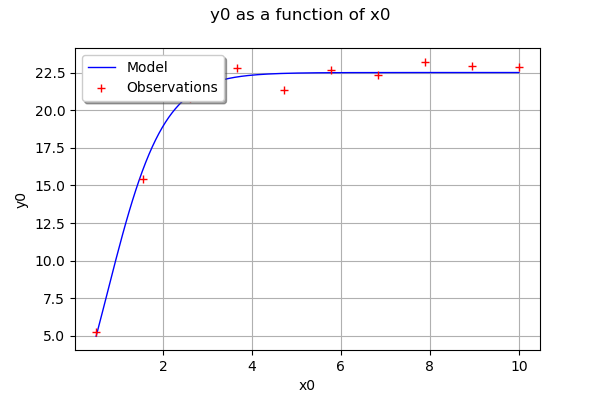

In [73]:
# Visualisation of the observations
functionnalModel = ot.ParametricFunction(fullModel, [1,2,3], logthetatrue)
graphModel = functionnalModel.getMarginal(0).draw(tmin,tmax)
observations = ot.Cloud(x_obs,y_obs)
observations = ot.Cloud(x_obs,y_obs)
observations.setColor("red")
graphModel.add(observations)
graphModel.setLegends(["Model","Observations"])
graphModel.setLegendPosition("topleft")
graphModel

Define the mean $\mu_\theta$, the covariance matrix $\Sigma_\theta$, then the prior distribution $\pi(\underline{\theta})$ of the parameter $\underline{\tilde \theta}$.

In [74]:
# Means of parameters
parameterPriorMean = ot.Point([np.log(0.5),np.log(12),np.log(6)])

#Number of parameters
paramDim = parameterPriorMean.getDimension()

#Standard deviations (here we recall that we are using the log values)
sigma0 = ot.Point([0.3,0.3,0.3])

# Covariance matrix
thetaPriorCovarianceMatrix = ot.CovarianceMatrix(paramDim)
for i in range(paramDim):
    thetaPriorCovarianceMatrix[i, i] = sigma0[i]**2

# Prior distribution of the parameters
prior =ot.Normal(parameterPriorMean, thetaPriorCovarianceMatrix)
prior.setDescription(['logE', 'logR', 'logP'])

Proposal distribution: uniform.

In [42]:
proposal = [ot.Uniform(-0.1, 0.1),ot.Uniform(-1., 1.),ot.Uniform(-1., 1.)]

Distribution of observations $\underline{Y^F} | \underline{Y^M}$ conditional on model predictions

In [43]:
conditional=ot.Normal(0,5)

We would like to approximate the posterior distribution of the parameters by the empirical distribution of the sample $\underline{\theta}^1, \ldots, \underline{\theta}^N$ generated by the Metropolis-Hastings algorithm. 

Creation of the Random Walk Metropolis-Hastings (RWMH) sampler

In [44]:
RWMHsampler = ot.RandomWalkMetropolisHastings( prior, conditional, model, x_obs, y_obs, parameterPriorMean,proposal)

We tune the RWMH algorithm.

We use the default strategy of calibration for the random walk.

In [45]:
strategy = ot.CalibrationStrategyCollection(paramDim)
RWMHsampler.setCalibrationStrategyPerComponent(strategy)

RWMHsampler.setVerbose(True)
RWMHsampler.setThinning(1)
RWMHsampler.setBurnIn(2000)

We generate a sample from the posterior distribution of the parameters $\tilde \theta$.

In [46]:
sampleSize = 10000
sample = RWMHsampler.getSample(sampleSize)

Let look at the acceptance rate (basic checking of the efficiency of the tuning; value close to 0.2 is usually recommended).

In [47]:
RWMHsampler.getAcceptanceRate()

class=Point name=Unnamed dimension=3 values=[0.775333,0.06775,0.295917]

We see that we can infer the CSF resistance to outflow as the efficiency of the tunning is good enought for this parameter. However, we did not obtain acceptable callibration for the other two parameters E and $p_b - p_0$. Actually the averaged intracranial pressure, is equally sensitive to those parameters and they compensate each other in the model. This shows the limitation of using the infusion test to infer the elsatance and the reference pressure $p_0$.

In order to visualize the posterior distributions of the parameters, we build the distribution of the posterior by kernel smoothing.

In [48]:
kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

Let display prior vs posterior for each parameter.

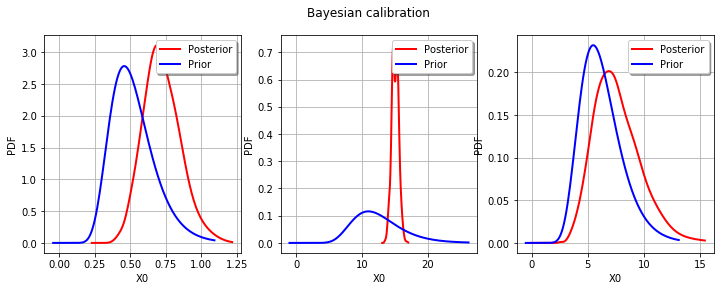

In [49]:
fig = pl.figure(figsize=(12, 4))

for parameter_index in range(paramDim):
    graph = posterior.getMarginal(parameter_index).exp().drawPDF()
    priorGraph = prior.getMarginal(parameter_index).exp().drawPDF()
    priorGraph.setColors(['blue'])
    graph.add(priorGraph)
    graph.setLegends(['Posterior', 'Prior'])
    ax = fig.add_subplot(1, paramDim, parameter_index+1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")

We can see that the posterior distributions for the parameters $\theta$ are arround the "true" values $\theta_T$.  The distribution is much narrower for $R_{CSF}$ as expected. The posterior distribution for the parametres E and $p_b - p_0$ are large thus the incertitudes after callibration are higher for those parameters. 

In [51]:
print('The "true" value of the parameters was : E = %.2f /ml, R = %.2f mmHg/(ml/min) and pb - p0 = %.2f '%(thetatrue[0],thetatrue[1],thetatrue[2]))

The "true" value of the parameters was : E = 0.80 /ml, R = 15.00 mmHg/(ml/min) and pb - p0 = 7.00 


### Using the surrogate model

Let compare the results with the callibration of paramters using the surrogate model $\hat P^M$.

Here the trick is to use as input $i_t\in N$ instead to the time. The indexs $x_i$ corresponds to the times used to build the surrogate model.

We define the function:

In [56]:
def PIC_itlogarg(x):
    """
    Input : 
    x : array of floats [t, E, RCSF,P0,Pb, Iinf]
        with : 
        t : time after the begining of infusion test
        E : elastance coefficient
        Rcsf : resistance to reabsoption of the CSF
        P0: reference pressure
        Pb : baseline intracranial pressure
        Iinf : infusion rate
    
    Output : 
    p : intracranial pressure
    """
    
    x=np.hstack(x)

    it,logE, logRCSF,logPbmP0=x
    
    E=np.exp(logE)
    R=np.exp(logRCSF)
    PB=np.exp(logPbmP0)
    
    #Metamodel
    p=krigingMeta([E,R,PB])[int(it)]
   
    return [p]

The callibration method is then the same as with the foward model $P^M$.

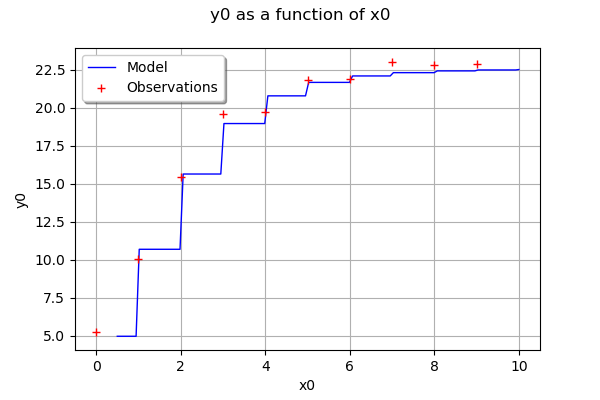

In [75]:
def g(X):
    p = PIC_itlogarg(X)[0]
    sigmap = 2 # (mmHg) The standard deviation of the observation error.
    return [p,sigmap]

fullModel = ot.PythonFunction(4, 2, g)

#Then we define the parametric model g. Here the input variable $t$ has the index 0.

input_indexes=[0]
arbitrary_inputs=[0]
model = ot.ParametricFunction(fullModel, input_indexes, arbitrary_inputs)

#Let say that we have 10 points of observations, ie. 10 points of measurement for the intracranial pressure at differents times. Each observation points is associated with an uncertainly. 

#We define the times of obervations

obs_dim=10
#### Fabrication des iterations d'observation
step = 1
rg = ot.RegularGrid(0, step, obs_dim)
x_obs = rg.getVertices()

#We define the observation noise 

ot.RandomGenerator.SetSeed(0)
noiseStandardDeviation = 0.5 ##mmHg
noise = ot.Normal(0,noiseStandardDeviation)
noiseSample = noise.getSample(obs_dim)

#We define the vector of observations, using the "true" value of the parameters.

y_obs = ot.Sample(obs_dim,1)
for i in range(obs_dim):
    model.setParameter(x_obs[i])
    y_obs[i,0] = model(logthetatrue)[0] + noiseSample[i,0]

# Visualisation of the observations
functionnalModel = ot.ParametricFunction(fullModel, [1,2,3], logthetatrue)
graphModel = functionnalModel.getMarginal(0).draw(tmin,tmax)
observations = ot.Cloud(x_obs,y_obs)
observations = ot.Cloud(x_obs,y_obs)
observations.setColor("red")
graphModel.add(observations)
graphModel.setLegends(["Model","Observations"])
graphModel.setLegendPosition("topleft")
graphModel

In [76]:
# Means of parameters
parameterPriorMean = ot.Point([np.log(0.5),np.log(12),np.log(6)])

#Number of parameters
paramDim = parameterPriorMean.getDimension()

#Standard deviations (here we recall that we are using the log values)
sigma0 = ot.Point([0.3,0.3,0.3])

# Covariance matrix
thetaPriorCovarianceMatrix = ot.CovarianceMatrix(paramDim)
for i in range(paramDim):
    thetaPriorCovarianceMatrix[i, i] = sigma0[i]**2

# Prior distribution of the parameters
prior =ot.Normal(parameterPriorMean, thetaPriorCovarianceMatrix)
prior.setDescription(['logE', 'logR', 'logP'])

#Proposal distribution: uniform.

proposal = [ot.Uniform(-0.1, 0.1),ot.Uniform(-1., 1.),ot.Uniform(-1., 1.)]

# Distribution of observations conditional on model predictions

conditional=ot.Normal(0,5)

#Creation of the Random Walk Metropolis-Hastings (RWMH) sampler

RWMHsampler = ot.RandomWalkMetropolisHastings( prior, conditional, model, x_obs, y_obs, parameterPriorMean,proposal)

# We tune the RWMH algorithm with default strategy of calibration for the random walk.

strategy = ot.CalibrationStrategyCollection(paramDim)
RWMHsampler.setCalibrationStrategyPerComponent(strategy)

RWMHsampler.setVerbose(True)
RWMHsampler.setThinning(1)
RWMHsampler.setBurnIn(2000)

# We generate a sample from the posterior distribution of the parameters 

sampleSize = 10000
sample = RWMHsampler.getSample(sampleSize)

# Let look at the acceptance rate

RWMHsampler.getAcceptanceRate()

class=Point name=Unnamed dimension=3 values=[0.714167,0.0714167,0.218583]

In [77]:
# In order to visualize the posterior distributions of the parameters, we build the distribution of the posterior by kernel smoothing.

kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

Let display prior vs posterior for each parameter.

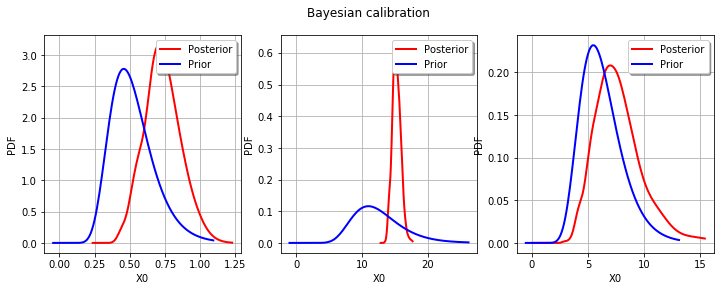

In [78]:
fig = pl.figure(figsize=(12, 4))

for parameter_index in range(paramDim):
    graph = posterior.getMarginal(parameter_index).exp().drawPDF()
    priorGraph = prior.getMarginal(parameter_index).exp().drawPDF()
    priorGraph.setColors(['blue'])
    graph.add(priorGraph)
    graph.setLegends(['Posterior', 'Prior'])
    ax = fig.add_subplot(1, paramDim, parameter_index+1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")

In [79]:
print('Reminder : The "true" value of the parameters was : E = %.2f /ml, R = %.2f mmHg/(ml/min) and pb - p0 = %.2f '%(thetatrue[0],thetatrue[1],thetatrue[2]))

Reminder : The "true" value of the parameters was : E = 0.80 /ml, R = 15.00 mmHg/(ml/min) and pb - p0 = 7.00 


We find a similar result with the surrogate model and with the foward computational model.

### References



1. Czosnyka M, Pickard JD (2004) Monitoring and interpretation of intracranial pressure. J Neurol Neurosurg Psychiatry 75(6):813–821

2. Marmarou A, Bergsneider M, Klinge P, Relkin N, Black PM (2005) The value of supplemental prognostic tests for the preoperative assessment of idiopathic normal-pressure hydrocephalus. Neurosurgery 57(3 Suppl):S17-28; discussion ii-v